## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'koa-biotech'

In [2]:
REGION = 'europe-west1'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'datalake'
BQ_TABLE = '011_disagg_binary'

In [3]:
from google.cloud import bigquery
from google.cloud import storage

In [4]:
bq = bigquery.Client(project = PROJECT_ID)
gcs = storage.Client(project = PROJECT_ID)

In [5]:
BUCKET = PROJECT_ID

## Read data

In [6]:
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [7]:
df.head()

,Class,LAS_abs,TRA_abs,LUX_abs,RHL_abs,CQSS_abs,AHY_abs,CEP_abs,CVI_abs,RSTA_abs,...,LUX_gfp,RHL_gfp,CQSS_gfp,CQSSNo_gfp,AHY_gfp,CEP_gfp,CVI_gfp,RSTA_gfp,Blanc_gfp,split
0,True,220,228,225,222,219,226,220,226,219,...,112,115,117,<NA>,110,109,109,105,93,TRAIN
1,True,210,216,217,221,213,219,213,225,217,...,114,120,116,<NA>,119,116,117,112,103,TEST
2,True,209,212,217,214,214,218,207,227,223,...,115,119,120,<NA>,124,118,120,119,102,TRAIN
3,True,208,213,215,213,214,221,219,226,220,...,115,116,117,<NA>,115,118,116,112,107,TRAIN
4,True,209,218,211,210,195,199,204,224,209,...,115,122,115,<NA>,114,117,113,113,104,TRAIN


## Input Analysis
1. Summary statistic of numeric features
2. Evaluate Class distribution globally and across splits
3. Histograms and boxplots of numeric features (detect outliers)
4. Heatmap between pairs of features to identify collinearity
5. Pairplots with class as color

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Summary statistic

In [9]:
df[df.select_dtypes(include='number').columns] = df.select_dtypes(include='number').astype(float)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Class       672 non-null    boolean
 1   LAS_abs     672 non-null    float64
 2   TRA_abs     672 non-null    float64
 3   LUX_abs     672 non-null    float64
 4   RHL_abs     672 non-null    float64
 5   CQSS_abs    672 non-null    float64
 6   AHY_abs     672 non-null    float64
 7   CEP_abs     672 non-null    float64
 8   CVI_abs     672 non-null    float64
 9   RSTA_abs    672 non-null    float64
 10  Blanc_abs   672 non-null    float64
 11  LAS_gfp     672 non-null    float64
 12  TRA_gfp     672 non-null    float64
 13  LUX_gfp     672 non-null    float64
 14  RHL_gfp     672 non-null    float64
 15  CQSS_gfp    672 non-null    float64
 16  CQSSNo_gfp  568 non-null    float64
 17  AHY_gfp     672 non-null    float64
 18  CEP_gfp     672 non-null    float64
 19  CVI_gfp     672 non-null    f

In [11]:
df.describe()

,LAS_abs,TRA_abs,LUX_abs,RHL_abs,CQSS_abs,AHY_abs,CEP_abs,CVI_abs,RSTA_abs,Blanc_abs,...,TRA_gfp,LUX_gfp,RHL_gfp,CQSS_gfp,CQSSNo_gfp,AHY_gfp,CEP_gfp,CVI_gfp,RSTA_gfp,Blanc_gfp
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,...,672.000000,672.000000,672.000000,672.000000,568.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,228.830357,226.610119,232.096726,225.587798,231.886905,218.251488,222.538690,233.791667,232.699405,193.023810,...,130.269345,131.538690,133.377976,134.053571,124.843310,127.377976,127.616071,125.427083,121.500000,112.375000
std,12.716481,11.539594,10.007502,14.706914,14.025387,21.193259,18.172013,13.165282,15.423349,20.393287,...,14.948807,15.517933,15.345014,17.583612,13.110778,15.019510,14.758208,15.147778,15.349578,18.211602
min,185.000000,188.000000,189.000000,166.000000,182.000000,146.000000,148.000000,184.000000,175.000000,136.000000,...,89.000000,87.000000,91.000000,91.000000,87.000000,88.000000,86.000000,85.000000,81.000000,68.000000
25%,220.000000,219.000000,226.000000,218.000000,220.000000,210.000000,215.000000,227.000000,221.000000,178.000000,...,120.000000,122.000000,124.000000,126.000000,116.000000,118.000000,119.000000,116.000000,111.000000,100.000000
50%,229.000000,227.000000,234.000000,229.000000,237.000000,222.000000,226.000000,237.000000,237.500000,194.000000,...,135.000000,137.000000,138.000000,136.000000,128.000000,130.000000,131.000000,130.000000,126.000000,115.000000
75%,239.000000,235.000000,239.000000,236.000000,244.000000,234.000000,235.000000,244.000000,245.000000,208.000000,...,141.000000,143.000000,145.000000,142.000000,134.000000,139.000000,139.000000,137.000000,133.000000,127.250000
max,252.000000,250.000000,250.000000,248.000000,251.000000,248.000000,249.000000,252.000000,253.000000,245.000000,...,157.000000,156.000000,158.000000,223.000000,158.000000,156.000000,154.000000,154.000000,145.000000,147.000000


### Class distribution

global

In [12]:
df['Class'].value_counts(normalize=True)

Class
True     0.791667
False    0.208333
Name: proportion, dtype: Float64

splits

In [13]:
df.groupby('split')['Class'].value_counts(normalize=True).unstack()

Class,False,True
split,,
TEST,0.176471,0.823529
TRAIN,0.206704,0.793296
VALIDATE,0.253731,0.746269


### Histograms and boxplots

In [14]:
for feature in df.select_dtypes(include='number').columns:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [15]:
numeric_features = df.select_dtypes(include='number').columns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


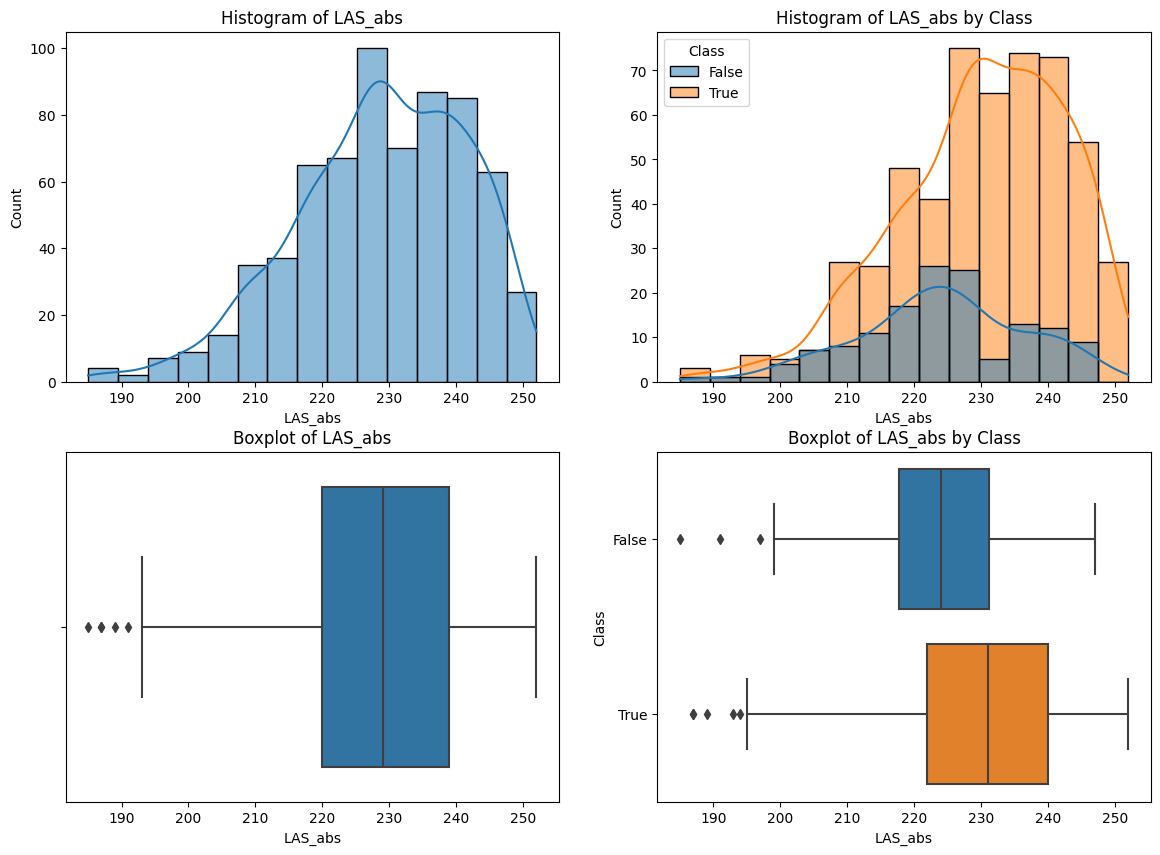

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


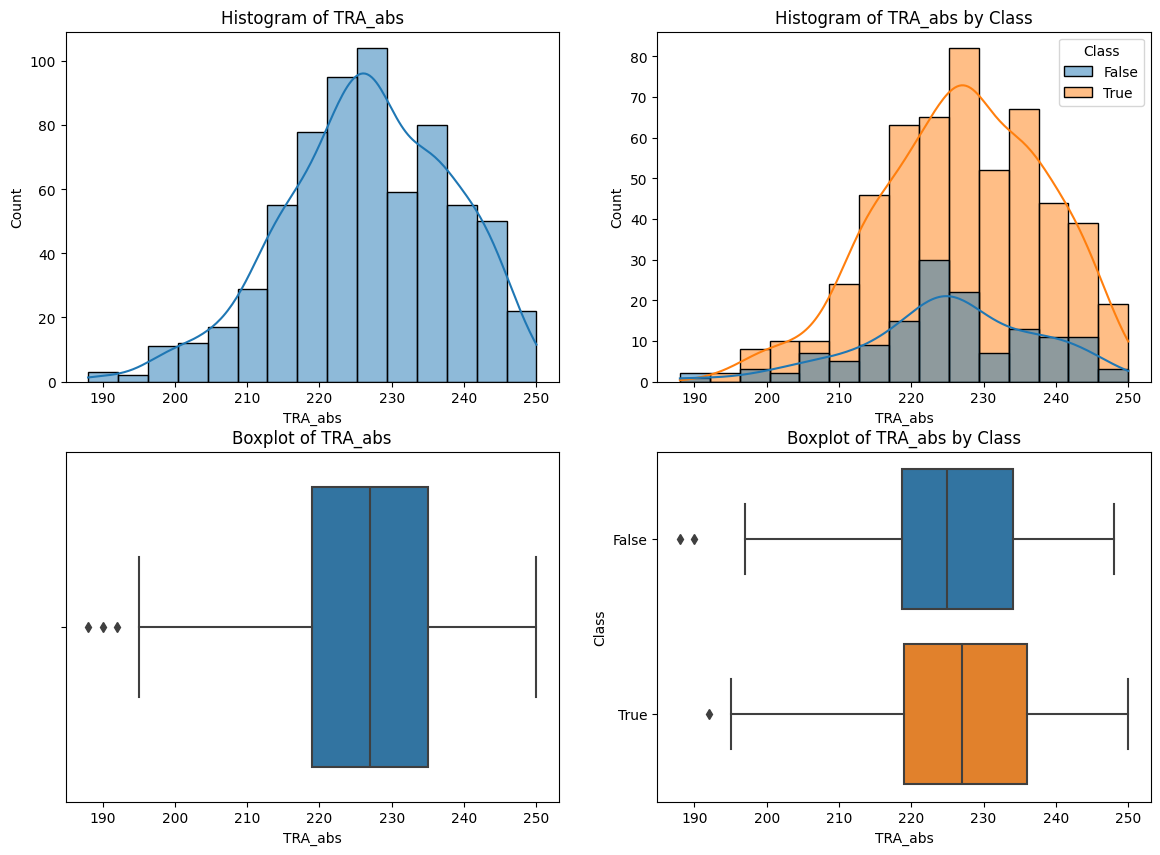

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


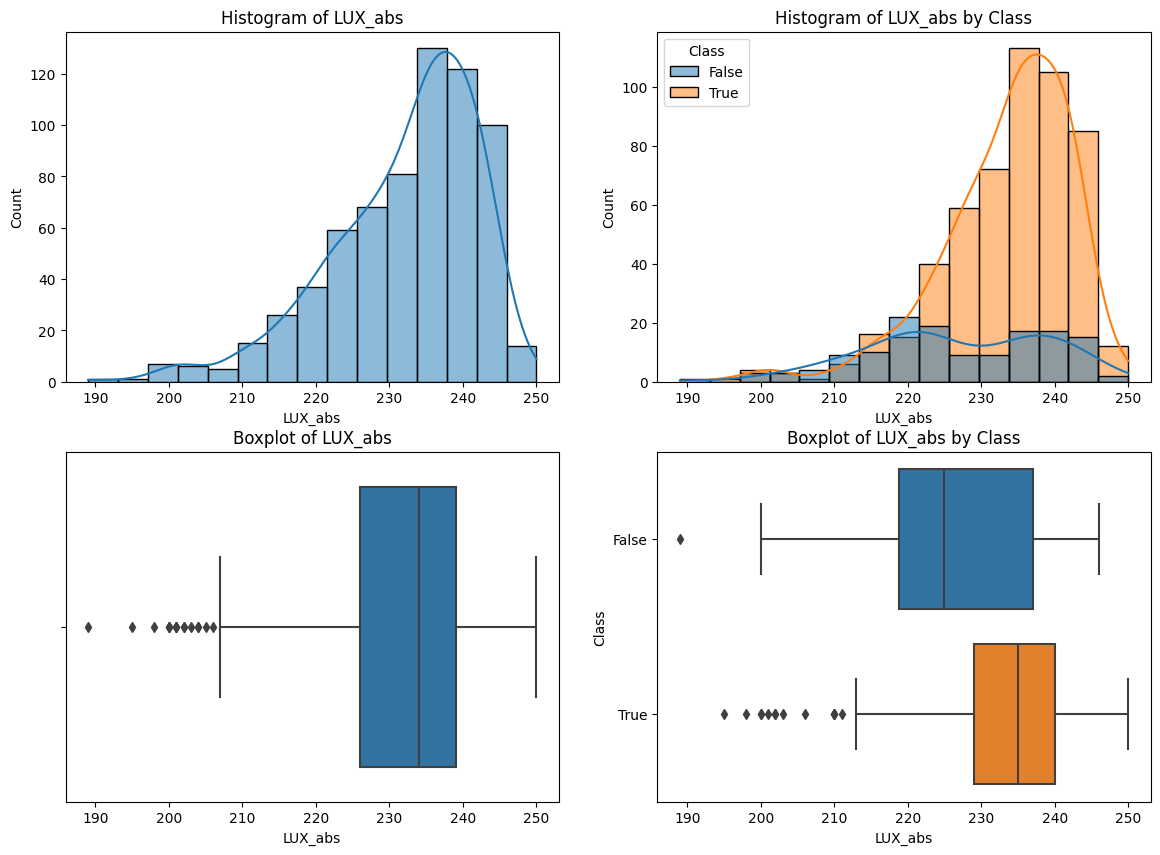

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


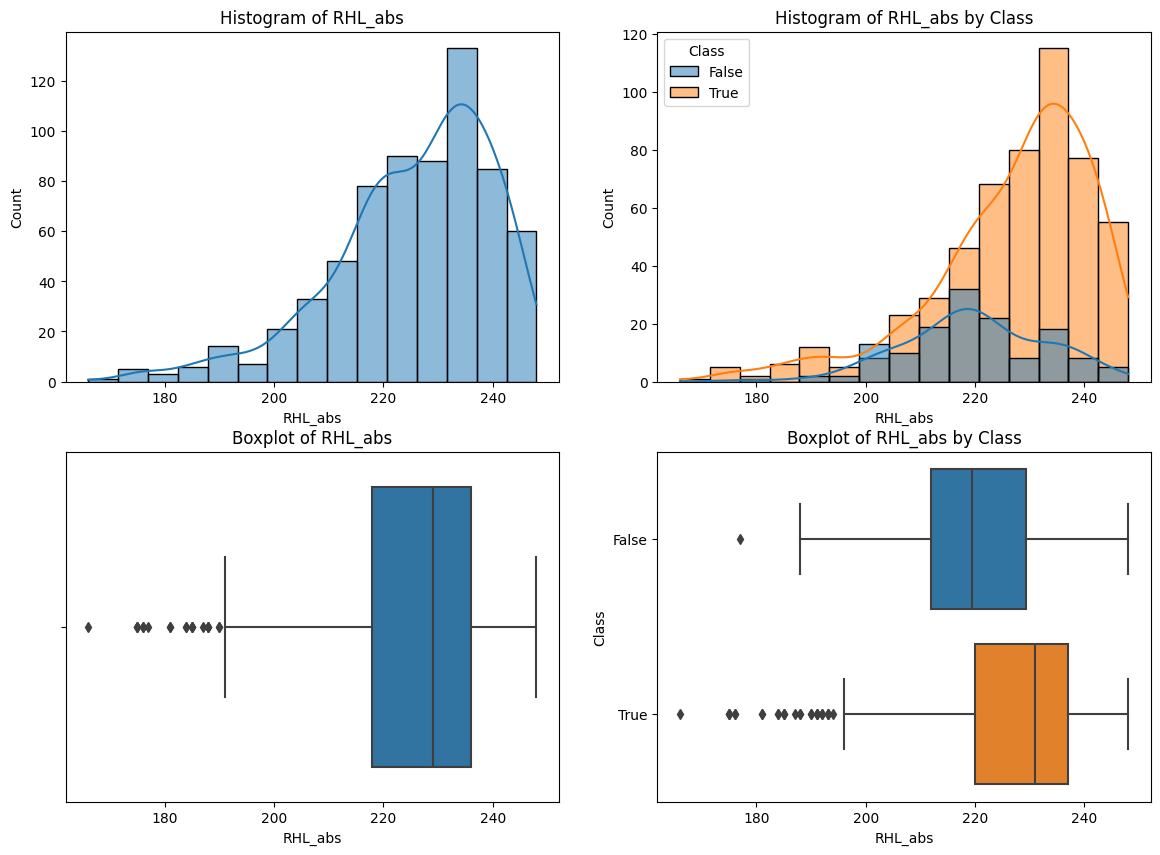

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


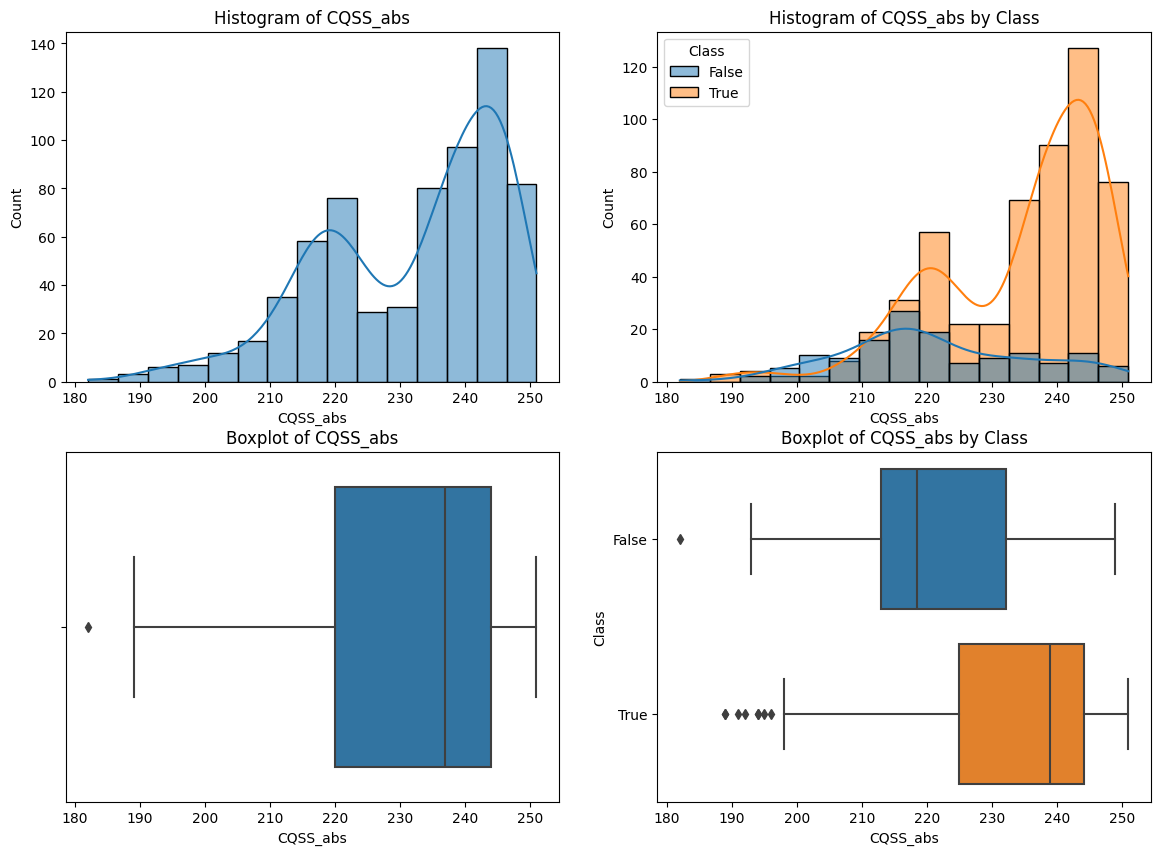

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


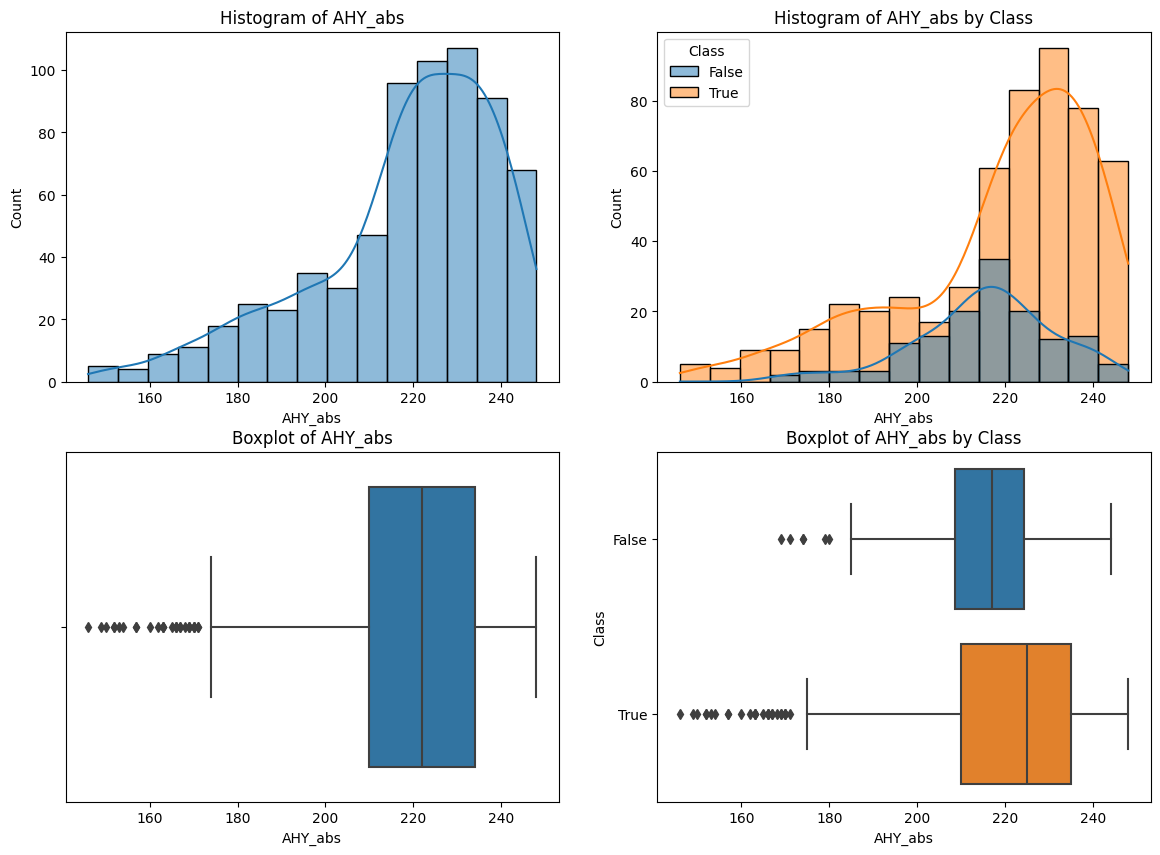

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


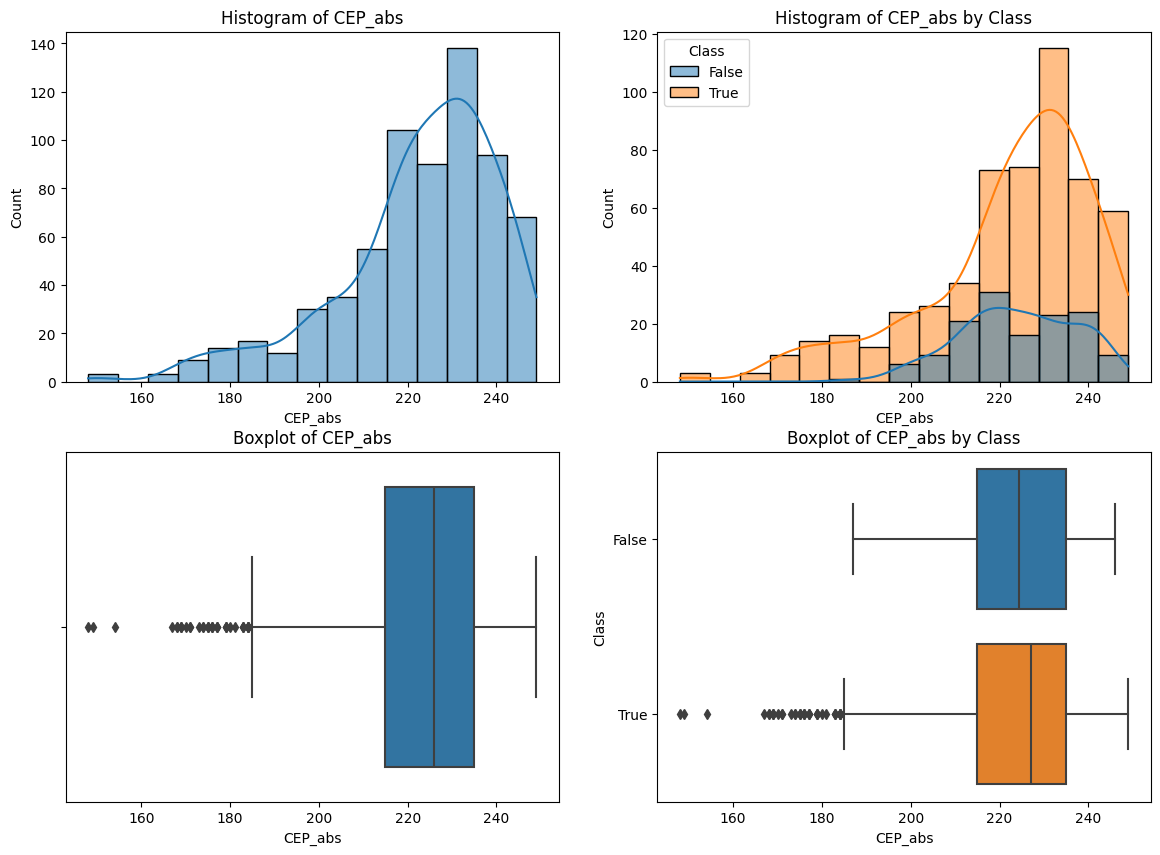

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


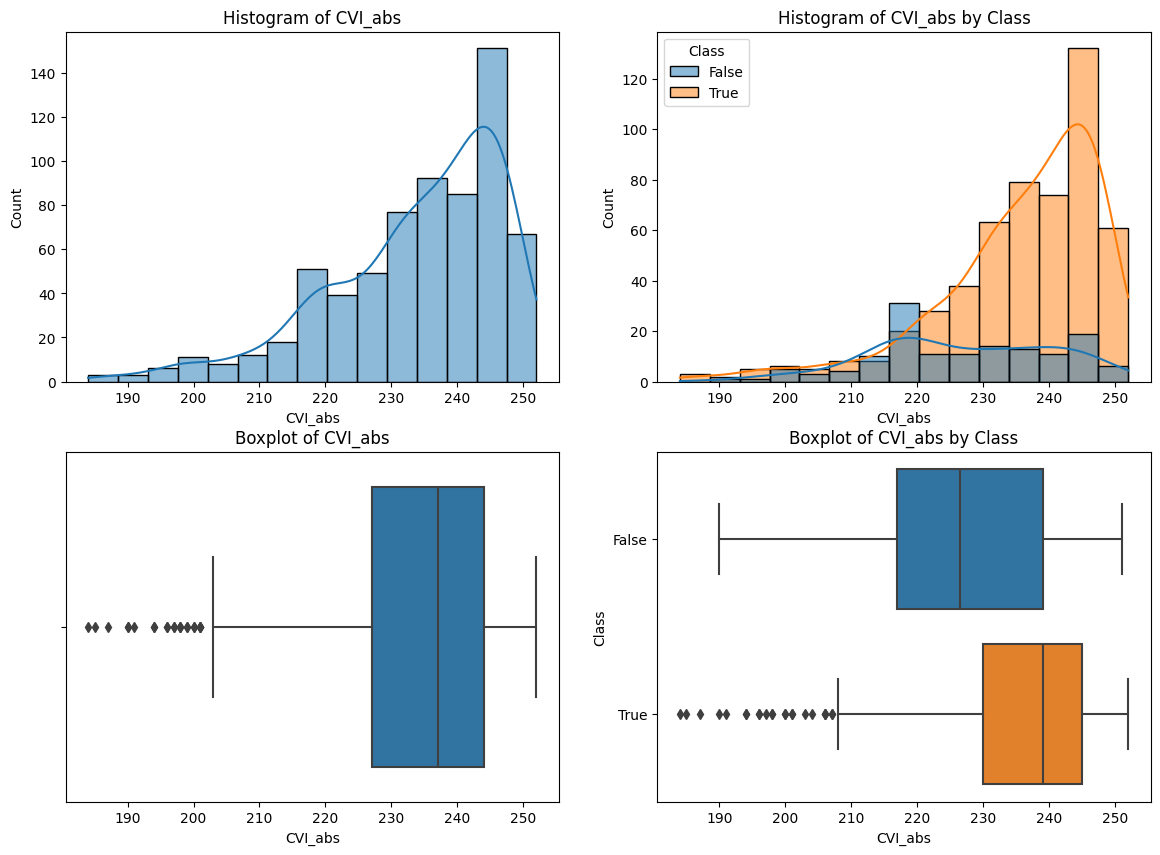

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


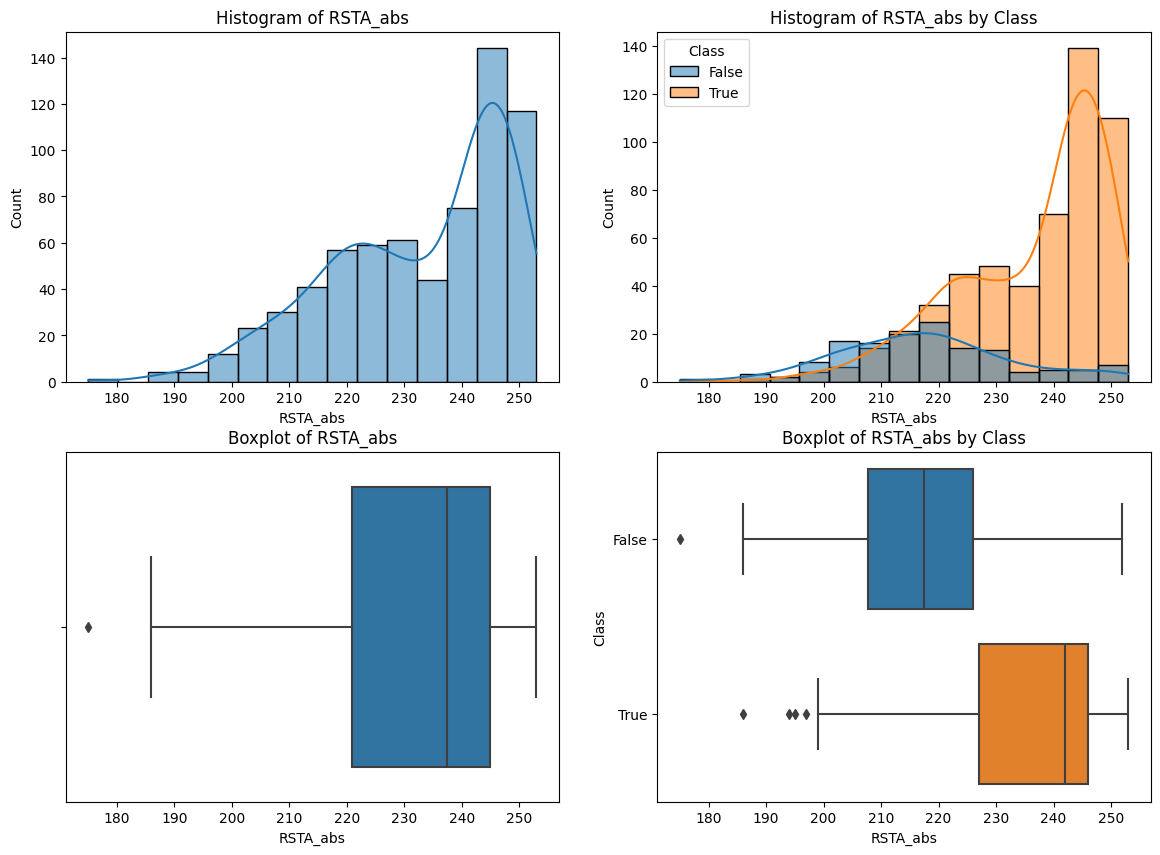

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


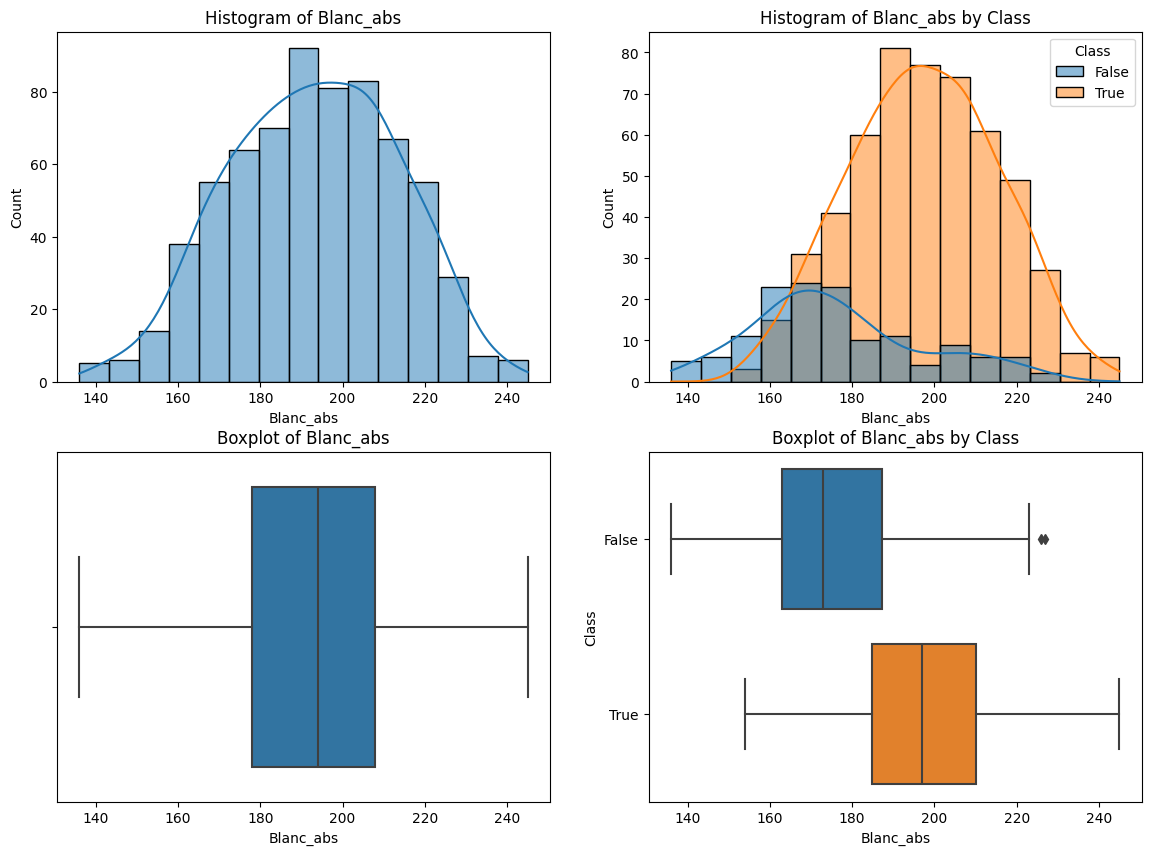

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


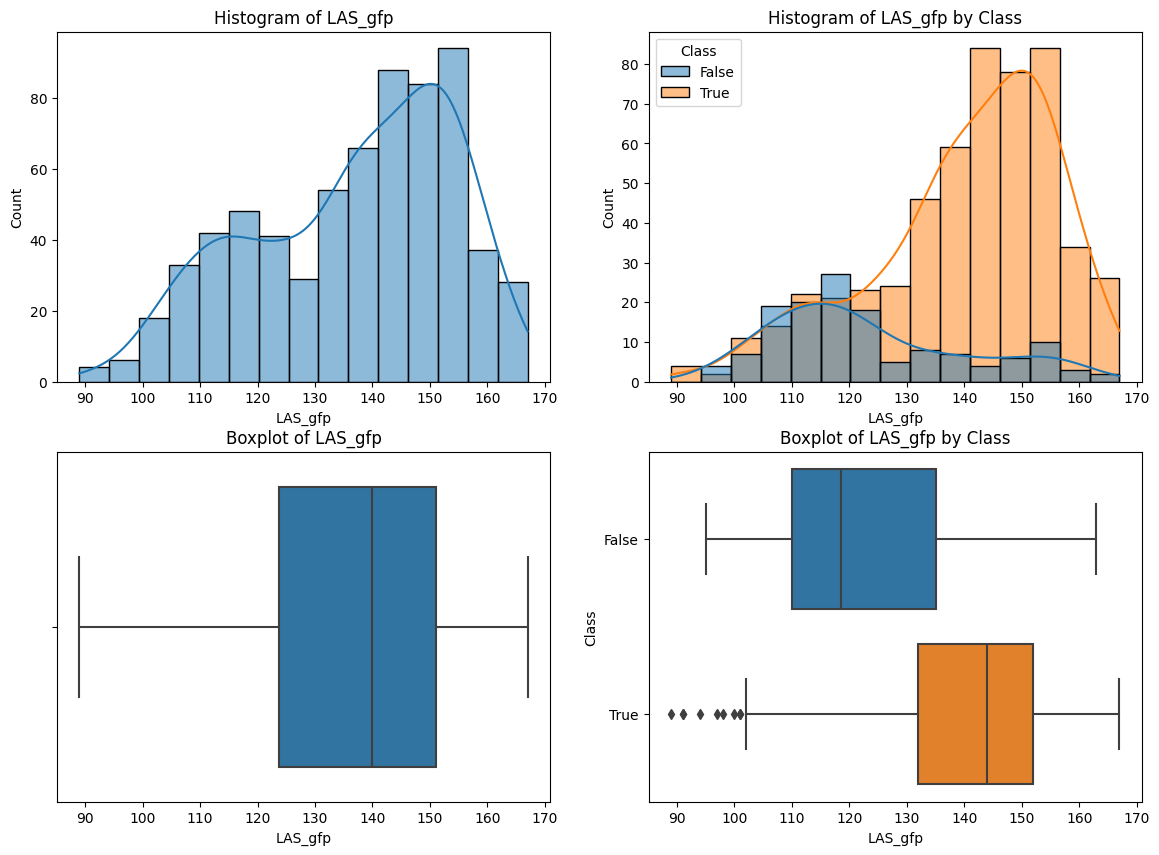

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


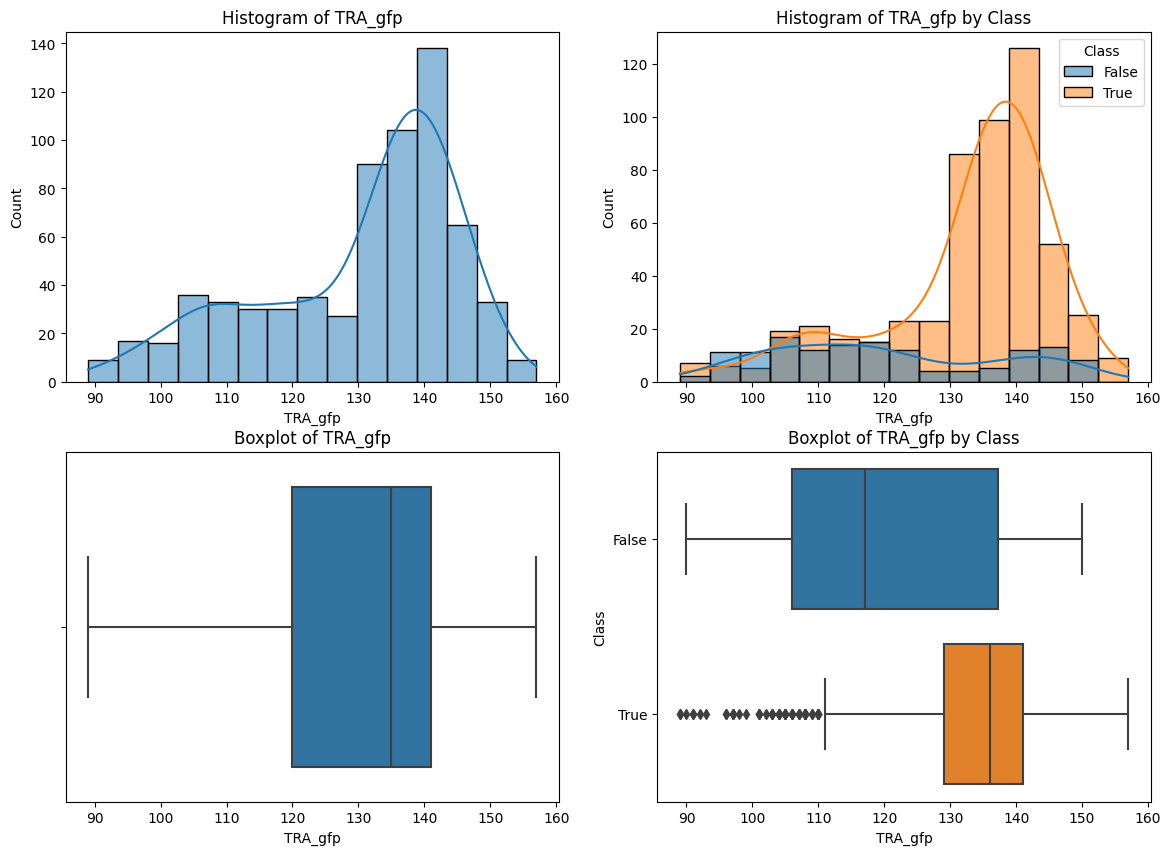

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


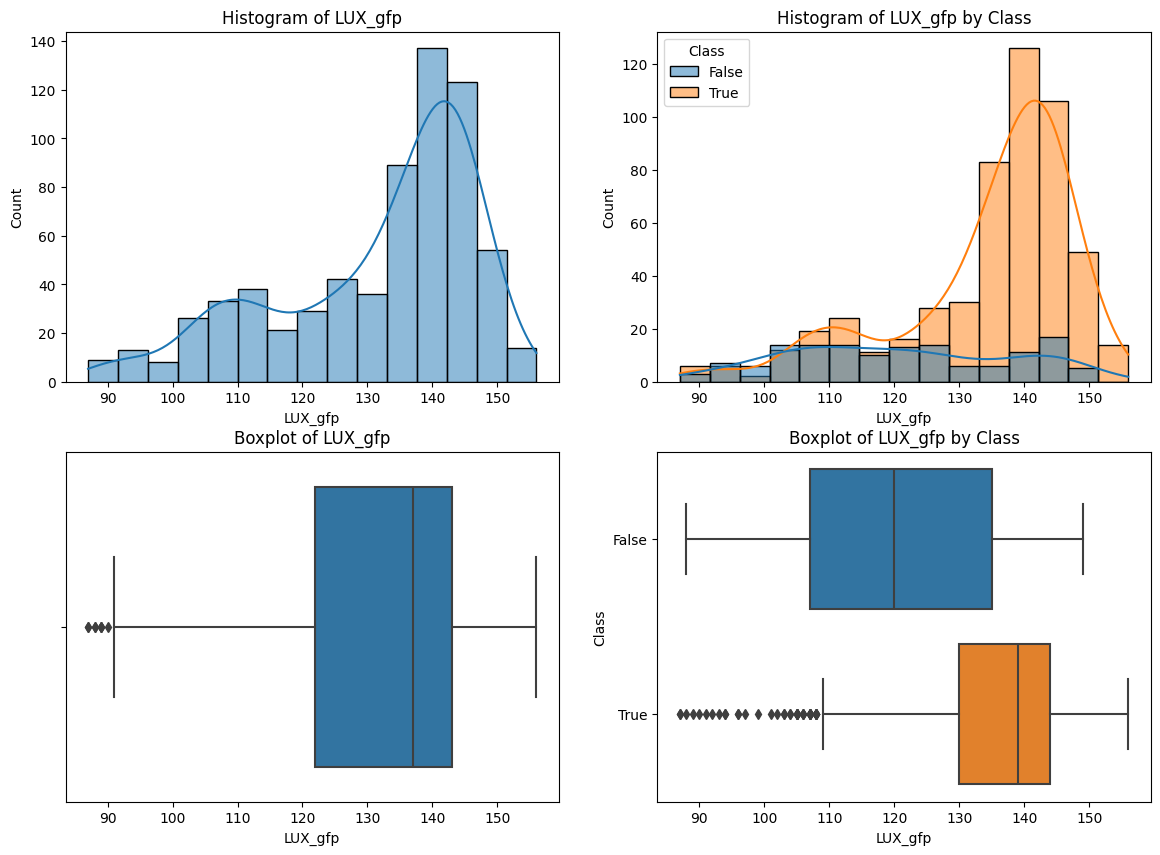

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [ ]:
for feature in numeric_features:
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    # Histogram for the feature
    sns.histplot(df[feature], bins=15, kde=True, ax=ax[0, 0])
    ax[0, 0].set_title(f'Histogram of {feature}')

    # Histogram of the feature divided by class
    sns.histplot(df, x=feature, hue='Class', bins=15, kde=True, ax=ax[0, 1])
    ax[0, 1].set_title(f'Histogram of {feature} by Class')
    
    # Boxplot for the feature
    sns.boxplot(x=feature, data=df, ax=ax[1, 0], orient='h')
    ax[1, 0].set_title(f'Boxplot of {feature}')

    # Boxplot of the feature divided by class
    sns.boxplot(y='Class', x=feature, data=df, ax=ax[1, 1], orient='h')
    ax[1, 1].set_title(f'Boxplot of {feature} by Class')

    plt.show()

### Correlation Heatmap

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Class', 'split']).corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Between Features')
plt.show()

### Pairplots

In [ ]:
sns.pairplot(df, hue='Class', corner=True)